# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

## 0. Importação de Pacotes e Dados

In [298]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [299]:
# Salva a base como variável "df"
df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


> Considerando que na atividade anterior foram considerados apenas os dados de 2020 em diante, será repetida esta condição. 

In [301]:
# Seleciona os dados a partir de 2020
df = df[(df.Ano >= 2020)]

## 1. Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

> Inserindo no df as __variáveis temporais__:

In [304]:
# Insere coluna com os dias da semana no df 
df["Dia Semana"] = df["Data Registro"].dt.weekday
dia_semana = {0: "Segunda-feira", 1: "Terça-feira", 2:"Quarta-feira", 
              3: "Quinta-feira", 4: "Sexta-feira", 5: "Sábado", 6: "Domingo"}
df["Dia Semana"] = df["Dia Semana"].map(dia_semana)

# Coluna dummy para fim de semana
df["Fim Semana"] = df["Dia Semana"].isin(['Sábado', 'Domingo']).astype(int)

# Coluna com os dias de cada mes
df["Dia Mes"] = df["Data Registro"].dt.day

# Coluna com o mês
df['Mes'] = df["Data Registro"].dt.month

# Coluna com o trimestre
df['Trimestre'] = df["Data Registro"].dt.quarter

> Colunas de categorização da variável ```Valor NF```:


In [306]:
# Categorizacao em 5 categorias
df["VNF 5"] = pd.qcut(df["Valor NF"], 5, duplicates='drop')

# Categorizacao em 10 categorias
df["VNF 10"] = pd.qcut(df["Valor NF"], 10, duplicates='drop')

# Categorizacao em 10 categorias
df["VNF 20"] = pd.qcut(df["Valor NF"], 20, duplicates='drop')

# Categorizacao em 50 categorias
df["VNF 50"] = pd.qcut(df["Valor NF"], 50, duplicates='drop')

## 2. Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

> Construção de metadados com as variáveis criadas (atuam como covariáveis) e a ```flag_credito``` (variável resposta):

In [309]:
# Variáveis criadas anteriormente
colunas = ['flag_credito', 'Dia Semana', 'Fim Semana', 
           'Dia Mes', 'Mes', 'Trimestre', 'VNF 5', 
           'VNF 10', 'VNF 20', 'VNF 50', ]

# Dataframe com os tipos das variaveis criadas e a variavel resposta
metadados = pd.DataFrame({'dtype': df[colunas].dtypes})
metadados['papel'] = 'covariável'
metadados.loc['flag_credito', 'papel'] = 'resposta'
metadados['nunique'] = df[colunas].nunique()
metadados

,dtype,papel,nunique
flag_credito,int64,resposta,2
Dia Semana,object,covariável,7
Fim Semana,int32,covariável,2
Dia Mes,int32,covariável,31
Mes,int32,covariável,12
Trimestre,int32,covariável,4
VNF 5,category,covariável,5
VNF 10,category,covariável,10
VNF 20,category,covariável,20
VNF 50,category,covariável,50


> Função que calcula o IV de cada variável desenvolvida em aula: 

In [311]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

> Cálculo do IV de cada variável:

In [313]:
for var in metadados[metadados.papel=='covariável'].index:
    metadados.loc[var, 'IV'] = IV(df[var], df.flag_credito)
metadados

,dtype,papel,nunique,IV
flag_credito,int64,resposta,2,NaN
Dia Semana,object,covariável,7,0.003964
Fim Semana,int32,covariável,2,0.003143
Dia Mes,int32,covariável,31,0.013840
Mes,int32,covariável,12,0.009169
Trimestre,int32,covariável,4,0.003454
VNF 5,category,covariável,5,0.039086
VNF 10,category,covariável,10,0.059155
VNF 20,category,covariável,20,0.078405
VNF 50,category,covariável,50,0.122328


## 3. Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

>  Avaliando o poder de discriminação de cada variável criada de acordo com a tabela de Naeem Siddiqi
> |Faixa|Poder preditivo|
|:-|:-|
|0 a 0,02| Inútil |
|0,02 a 0,1| Fraco |
|0,1 a 0,3| Médio |
|0,3 a 0,5| Forte |
|0,5 ou mais| Suspeito de tão alto |
> 
> Observa-se que as variáveis temporais são inúteis ou fracas, com as mais relevantes sendo ```Dia Mes```, possivelmente, ligado ao dia do pagamento, onde pode haver maior número de compras.
> 
> Em relação às variáveis contínuas categorizadas, nota-se que quanto maior o número de categorias, maior o IV. Isso induz ao uso da ```VNF 50``` para a análise desse trabalho.

## 4. Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

> Para montar os gráficos pedidos, será feita uma tabela da variável ```flag_credito``` em função do período trimestral e categoria de estabelecimento de onde foi feita a nota. A partir disso, serão contadas as quantidades de nota e a proporção de notas com crédito. 

In [318]:
# Tabela com as quantidades mencionadas acima
tab = pd.crosstab(index=[df.Trimestre, df.categoria], columns=df.flag_credito)
tab['Quantidade'] = tab.sum(axis=1)
tab['Proporcao'] = tab[1]/tab['Quantidade']
tab.drop(index=[(1,'não definido'), (2,'não definido'),
                (3,'não definido'), (4,'não definido')],
                inplace=True)
tab

flag_credito               0     1  Quantidade  Proporcao
Trimestre categoria                                      
1         Alimentos      367   897        1264   0.709652
          Auto posto     116    34         150   0.226667
          Construção    2031  1790        3821   0.468464
          Farmácia      1769   622        2391   0.260142
          Mercado       3476  3248        6724   0.483046
          Restaurantes   161   568         729   0.779150
          Varejo         777   168         945   0.177778
          Vestuário      315   115         430   0.267442
2         Alimentos      431   735        1166   0.630360
          Auto posto      87    28         115   0.243478
          Construção    2125  1676        3801   0.440937
          Farmácia      1679   810        2489   0.325432
          Mercado       3481  3115        6596   0.472256
          Restaurantes   132   299         431   0.693735
          Varejo        1115   151        1266   0.119273
          Vestuário      347    79         426   0.185446
3         Alimentos      383   856        1239   0.690880
          Auto posto      96    42         138   0.304348
          Construção    2089  2009        4098   0.490239
          Farmácia      1643   943        2586   0.364656
          Mercado       3718  3357        7075   0.474488
          Restaurantes   114   408         522   0.781609
          Varejo        1163   184        1347   0.136600
          Vestuário      337   117         454   0.257709
4         Alimentos      424   954        1378   0.692308
          Auto posto     105    31         136   0.227941
          Construção    2278  2048        4326   0.473417
          Farmácia      1513  1207        2720   0.443750
          Mercado       3704  3457        7161   0.482754
          Restaurantes   145   351         496   0.707661
          Varejo        1310   198        1508   0.131300
          Vestuário      478   132         610   0.216393

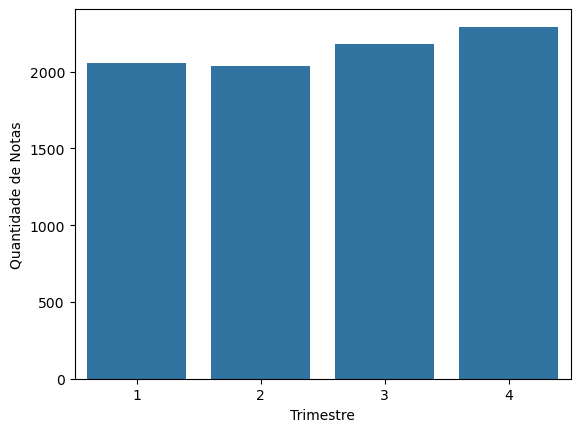

In [319]:
# Gráfico com quantidade de notas registradas por período trimestral
fig, ax = plt.subplots()
sns.barplot(data=tab, x='Trimestre', y='Quantidade', errorbar=None, ax=ax)
ax.set_ylabel('Quantidade de Notas')
plt.show()

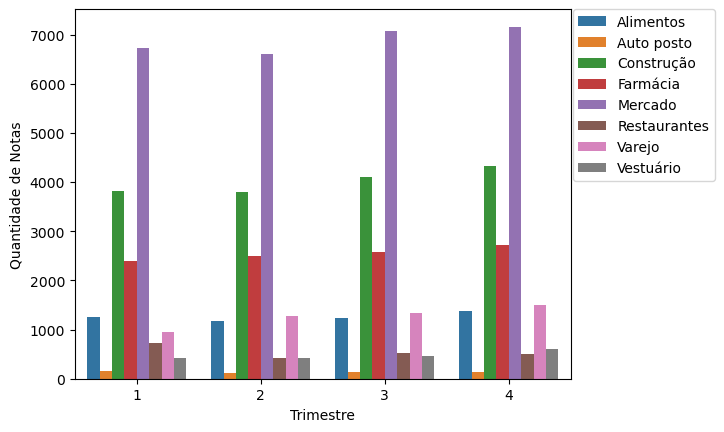

In [320]:
# Gráfico com quantidade de notas registradas por período trimestral
fig, ax = plt.subplots()
sns.barplot(data=tab, x='Trimestre', hue='categoria', y='Quantidade', ax=ax)
ax.set_ylabel('Quantidade de Notas')
plt.legend(loc='upper right', bbox_to_anchor=(1.29, 1), borderaxespad=0)
plt.show()

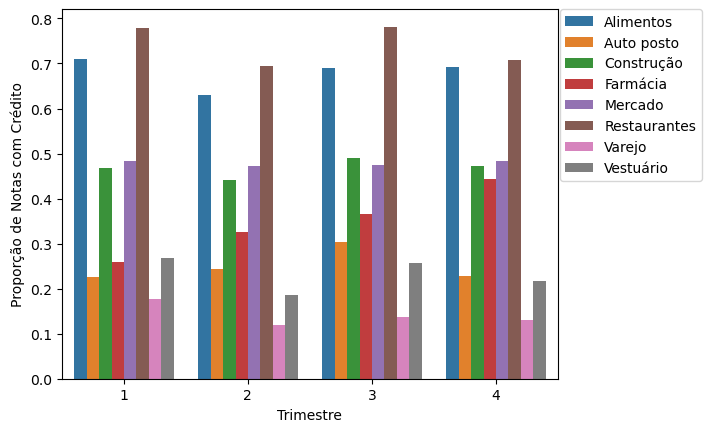

In [352]:
# Gráfico com quantidade de notas registradas por período trimestral
fig, ax = plt.subplots()
sns.barplot(data=tab, x='Trimestre', hue='categoria', y='Proporcao', ax=ax)
ax.set_ylabel('Proporção de Notas com Crédito')
plt.legend(loc='upper right', bbox_to_anchor=(1.29, 1), borderaxespad=0)
plt.show()

## 5. Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

> O WOE e o IV serão avaliados gráficamente. Para isso, serão calculados e adicionados em colunas na tabela criada.

In [344]:
# Calcula o WOE e o IV para cada categoria pelo tempo
tab['pct_evento']     = tab[1]/tab[1].groupby(level=0).sum()
tab['pct_nao_evento'] = tab[0]/tab[0].groupby(level=0).sum()
tab['WOE'] = np.log(tab.pct_evento/tab.pct_nao_evento)
tab['IV'] = (tab['pct_evento'] - tab['pct_nao_evento'])*tab.WOE
tab

flag_credito               0     1  Quantidade  Proporcao  pct_evento  \
Trimestre categoria                                                     
1         Alimentos      367   897        1264   0.709652    0.120532   
          Auto posto     116    34         150   0.226667    0.004569   
          Construção    2031  1790        3821   0.468464    0.240527   
          Farmácia      1769   622        2391   0.260142    0.083580   
          Mercado       3476  3248        6724   0.483046    0.436442   
          Restaurantes   161   568         729   0.779150    0.076324   
          Varejo         777   168         945   0.177778    0.022575   
          Vestuário      315   115         430   0.267442    0.015453   
2         Alimentos      431   735        1166   0.630360    0.106630   
          Auto posto      87    28         115   0.243478    0.004062   
          Construção    2125  1676        3801   0.440937    0.243145   
          Farmácia      1679   810        2489   0.325432    0.117511   
          Mercado       3481  3115        6596   0.472256    0.451908   
          Restaurantes   132   299         431   0.693735    0.043377   
          Varejo        1115   151        1266   0.119273    0.021906   
          Vestuário      347    79         426   0.185446    0.011461   
3         Alimentos      383   856        1239   0.690880    0.108135   
          Auto posto      96    42         138   0.304348    0.005306   
          Construção    2089  2009        4098   0.490239    0.253790   
          Farmácia      1643   943        2586   0.364656    0.119126   
          Mercado       3718  3357        7075   0.474488    0.424078   
          Restaurantes   114   408         522   0.781609    0.051541   
          Varejo        1163   184        1347   0.136600    0.023244   
          Vestuário      337   117         454   0.257709    0.014780   
4         Alimentos      424   954        1378   0.692308    0.113870   
          Auto posto     105    31         136   0.227941    0.003700   
          Construção    2278  2048        4326   0.473417    0.244450   
          Farmácia      1513  1207        2720   0.443750    0.144068   
          Mercado       3704  3457        7161   0.482754    0.412628   
          Restaurantes   145   351         496   0.707661    0.041895   
          Varejo        1310   198        1508   0.131300    0.023633   
          Vestuário      478   132         610   0.216393    0.015756   

flag_credito            pct_nao_evento       WOE        IV  
Trimestre categoria                                         
1         Alimentos           0.040723  1.085111  0.086601  
          Auto posto          0.012872 -1.035812  0.008600  
          Construção          0.225366  0.065105  0.000987  
          Farmácia            0.196294 -0.853812  0.096237  
          Mercado             0.385708  0.123575  0.006269  
          Restaurantes        0.017865  1.452134  0.084890  
          Varejo              0.086218 -1.340059  0.085286  
          Vestuário           0.034953 -0.816223  0.015917  
2         Alimentos           0.045866  0.843646  0.051264  
          Auto posto          0.009258 -0.823820  0.004281  
          Construção          0.226136  0.072522  0.001234  
          Farmácia            0.178674 -0.419035  0.025630  
          Mercado             0.370437  0.198794  0.016196  
          Restaurantes        0.014047  1.127526  0.033071  
          Varejo              0.118655 -1.689446  0.163452  
          Vestuário           0.036927 -1.169993  0.029795  
3         Alimentos           0.040134  0.991157  0.067400  
          Auto posto          0.010060 -0.639757  0.003041  
          Construção          0.218904  0.147873  0.005159  
          Farmácia            0.172168 -0.368291  0.019535  
          Mercado             0.389605  0.084784  0.002923  
          Restaurantes        0.011946  1.461991  0.057888  
          Varejo              0.121869 -1.656901  0.1

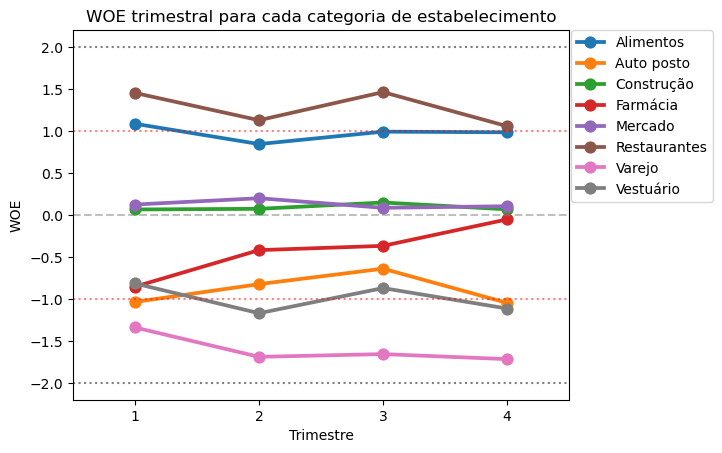

In [325]:
# Gráfico do WOE
fig, ax = plt.subplots()

# Insere os dados no gráfico
sns.pointplot(data=tab, y = 'WOE', x = 'Trimestre', hue='categoria', ax=ax)

# Títulos e legendas
plt.legend(loc='upper right', bbox_to_anchor=(1.29, 1), borderaxespad=0)
ax.set_title('WOE trimestral para cada categoria de estabelecimento')

# Linhas de referência
ax.axhline(2, linestyle=':'  , color='black', alpha=.5)
ax.axhline(1, linestyle=':'  , color='red', alpha=.5)
ax.axhline(0, linestyle='--' , color='grey', alpha=.5)
ax.axhline(-1, linestyle=':' , color='red', alpha=.5)
ax.axhline(-2, linestyle=':'  , color='black', alpha=.5)

# Mostra o gráfico
plt.show()

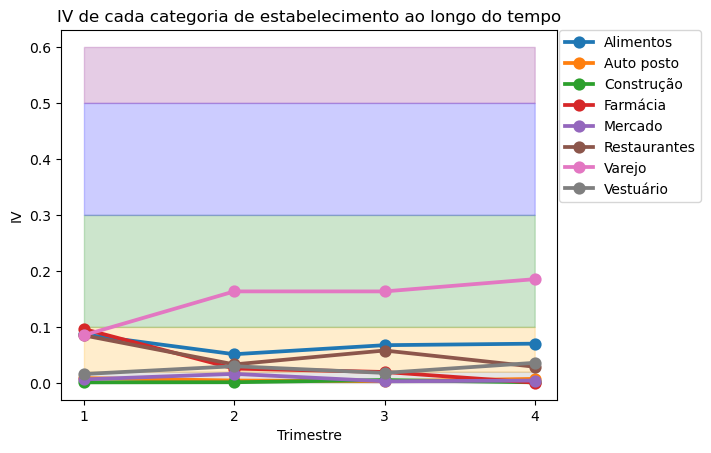

In [326]:
# Gráfico do IV
fig, ax = plt.subplots()

# Insere os dados no gráfico
sns.pointplot(data=tab, y = 'IV', x = 'Trimestre', hue='categoria', ax=ax)

# Títulos e legendas
plt.legend(loc='upper right', bbox_to_anchor=(1.29, 1), borderaxespad=0)
ax.set_title('IV de cada categoria de estabelecimento ao longo do tempo')

# Regiões de referência do poder preditivo da variável
intervalo = np.arange(0, 3, 0.001)
ax.fill_between(x=intervalo, y1=0, y2=0.02, color='grey', alpha=.2)
ax.fill_between(x=intervalo, y1=0.02, y2=0.1, color='orange', alpha=.2)
ax.fill_between(x=intervalo, y1=0.1, y2=0.3, color='green', alpha=.2)
ax.fill_between(x=intervalo, y1=0.3, y2=0.5, color='blue', alpha=.2)
ax.fill_between(x=intervalo, y1=0.5, y2=0.6, color='purple', alpha=.2)

# Mostra o gráfico
plt.show()

## 6. Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

> Os gráficos temporais das quantidades de notas emitidas no decorrer do tempo mostraram que há um aumento na quantidade de notas no decorrer do ano, com uma leve queda inesperada no segundo trimestre. Além disso, é perceptível que a proporção de notas com retornos maiores que zero tiveram predomínio pelas categorias _Alimentos_ e _Restaurantes_ durante todo o ano e que as diferenças entre as essas proporções quase não mudaram no período analisado.
>
> Em relação à leve queda no segundo trimestre, possivelmente foi causada pelo início da quarentena no ano de 2020 devido à pandemia do vírus COVID-19, que apresetou maiores quantidades de indivíduos desobecendo-a nos trimestres seguintes.
>
> Com exceção das categorias _Vestuário_, _Restaurantes_ e _Farmácia_ quase não houveram variações no WOE e no IV das categorias de estabelecimentos, de forma que apenas nas três mencionadas não é possível garantir segurança em seu poder preditivo no decorrer do tempo.   